## Project Bike Rentals

In this project a dataset of bike rentals in the Washington D.C. area will be explored. Different machine learning models will be created using the scikit-learn library to predict the amount of hourly rentals. The efficiency of the different models will then be compared.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import math

# Setup

Loading the Dataset

In [3]:
bike_rentals = pd.read_csv('hour.csv')
print(bike_rentals.shape)
bike_rentals.tail()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


## Dataset exploration:

The dataset has 17379 rows. Each of these corresponds to a single hour of bike rentals. 

columns:

* `instant`: unique identifier for every hour
* `dteday`: day on which the bike rentals occurred
* `season`: 1-4 corresponding to the season
* `yr`: year in which the bike rentals occurred (0: 2011, 1: 2012)
* `hr`: hour of the day
* `holiday`: whether the rental day was a holiday or not
* `weekday`: 0-6 (Sun - Sat)
* `workingday`: identifier of wheter the day was a workday
* `weathersit`: 1-4 identifier of the weather during the hour
* `temp`: 0-1 temperature scale
* `atemp`: adjusted temperature
* `hum`: humidity
* `windspeed`
* `casual`: amount of rentals of people not previously registered as renters
* `registered`: amount of rentals by previously registered users 
* `cnt`: combined count of both casual and registered users

All of the columns up to `windspeed` can be used to predict the target: `cnt`. `casual` and `registered` can't be used as they contain direct information on the number of rentals.

Text(0.5, 1.0, 'Typical Bike Rental Amounts')

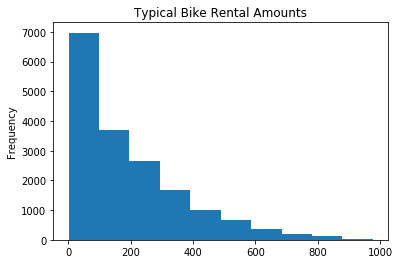

In [4]:
bike_rentals.cnt.plot.hist()
plt.title('Typical Bike Rental Amounts')

In most hour intervals between 0-100 bikes are rented each hour. This makes sense, since bikes are not useful at night and throughout most of the day. Very few intervals exceed 800 rentals. These exceptions are likely during summer on special occasions or on very nice days. When analyzing the efficiency of the models it is important to ensure that they do not only predict low bike rentals. A model that only predicts low bike rentals would in general look very accurate, due to the overwhelming amount of these hours, but this type of model would be completely useless

## Correlations

In [6]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

The columns that will be excluded (`casual` and `registered`) show the strongest correlation to the target column. This is not surprising as they contain the information of `cnt` directly. `registered` has a much stronger correlation than `casual`, implying that a majority of rentals is to repeat customers. 
Of the remaining columns, the strongest correlations are the two temperature columns (`temp`, `atemp`). Since these provide redundant information one should also be excluded from the analysis. The humidity column `hum` is also strongly correlated, but this could also provide redundant information to two temperature columns. The `hr` column also shows a strong correlation. This makes sense since riding a bike will have certain key hours.
This behavior can also be seen in the following heatmap:

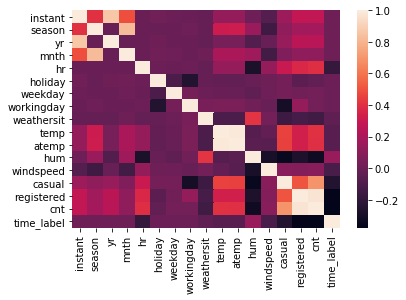

In [73]:
sns.heatmap(bike_rentals.corr())

## Transforming different features

The `hr` column can be transformed to provide more information to a machine learning algorithm. Categorizing the hours into times of the day (morning, afternoon, evening, night) would make this column more useful as a feature. The hours will be categorized in the following way:
* 6-12  -> 1
* 12-18 -> 2
* 18-24 -> 3
* 0-6   -> 4

In [8]:
def hr_cat(hr):
    '''Categorize the hours of the day into intervals
    Args:
        hr (int): hour of the day using 24 hr system
    Returns:
        int: category of hour
    '''
    if hr < 6:
        return 4
    elif hr < 12:
        return 1
    elif hr < 18:
        return 2
    else:
        return 3

In [9]:
bike_rentals['time_label'] = bike_rentals.hr.apply(hr_cat)

## Splitting the dataset into a training set and a test set

This is necessary when employing machine learning algorithms, because testing the algorithms on the same dataset as the one the models are trained on can mask issues with overfitting. This means that the algorithm basically memorizes the dataset instead of finding patterns in the dataset. This can cause a very high accuracy when predicting the training set, but causes the model to perform poorly on new data and generalizing very badly. In this case 80% of the dataset will be allocated to the training set and 20% to the test set. To make sure the model is not biased towards a subset of the dataset, the dataset will be randomized before dividing it into the two subsets. A random seed will be set to make the results reproducible.

In [10]:
np.random.seed(1)
bike_rentals = bike_rentals.reindex(np.random.permutation(bike_rentals.index))

In [11]:
splt_ind = math.floor(len(bike_rentals) * 0.8)
train = bike_rentals.iloc[:splt_ind].copy()
test = bike_rentals.loc[bike_rentals.index.isin(train.index) == False].copy()
train.sort_values('instant', inplace = True)
test.sort_values('instant', inplace = True)
bike_rentals.sort_values('instant' , inplace = True)

## Feature Selection:

First the features for use by the different machine learning models have to be selected:
* The `casual` and `registered` columns will be excluded because they contain all the information of cnt

* `instant` can be excluded, as it does not provide any information because it is just the unique identifier

* the only bit of unique information contained in `dteday` is the day of the month. This piece of information does not seem relevant in this case, since the part of the month should not impact how many bikes are rented, so it will be ignored.

* the rest of the features seem relevant:
    * `season`: people might be more likely to rent bikes in the spring and summer than in the winter and maybe autumn
    * `yr`: Interestingly enough this column showed strong correlation to the target column, so maybe the reason this dataset was collected was a change in the bike rental system in Washington D.C. or some other external factor made the rentals different in the two years (very rainy summer in the one year, publicity campaign drawing attention to the bike rental system, change in pricing model ...). But maybe this correlation is misleading and irrelevant.
    * `mnth`: This column has some redundant information with the `season column` but is more fine_grained. it is not normalized
    * `weekday`: seems very relevant as people are more likely to ride bikes in their free time on weekends and more likely to ride bikes to work within the week.
    * `workingday`: may provide mostly redundant information with weekday as most non-working days are sundays. The days off might be a valuable resource, though, so tranforming this column to show only non-sunday free days might be worth looking into.
    * `weathersit`: seems important, as most people will avoid riding bikes on rainy or snowy days
    * `temp` amd `atemp` are important indicators as one would expect there to be a Goldilocks zone for bike riding. They do, however provide redundant information and one should be chosen.
    * `hum`, `windspeed`: might provide complimentary information to `temp` and `weathersit`. 
    
    
The combination of the four columns giving information about the weather situation (`weathersit`, `temp` or `atemp`, `hum` and `windspeed`) will be particularly interesting. These all provide complimentary information. The `LinearRegression` model can't combine complimentary information as it treats the features as independent. Also these features don't necessarily interact linearly with the amount of bike riders. For example while a higher temperature is generally more likely to get more people on bikes, on a hot summer day above a certain point (30°C) less people will be likely to ride bikes. This is then also coupled with the humidity and wind indicator as well as the weather as perceived temperature depends heavily on these factors. The `DescisionTree` model should be much better suited to this type of data, as they can handle both non-linearities as well as features that influence each other.

## Linear Regression Model:

The first machine learning model that will be implemented will be a linear regression model. This type of machine learning model is particularly effective on datasets, where there is a strong correlation between independent features and the target column.

In [33]:
features = bike_rentals.columns[[2,3,4,6,7,9,10,11,12,13,-1]]
features

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

In [13]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [16]:
def train_and_test_linreg(features):
    '''Train and test a linear regression model
    Kwargs:
        features(list): list of features to use
    Returns:
        float, float: root mean squared error of the model divided by the averarge number of bike rentals in
        both the train and test set
    '''
    lr = LinearRegression(normalize = False)
    lr.fit(train[features], train.cnt)
    predictions_test = lr.predict(test[features])
    predictions_train = lr.predict(train[features])
    rmse_test = mean_squared_error(test.cnt, predictions_test)**0.5
    rmse_train = mean_squared_error(train.cnt, predictions_train)**0.5
    return rmse_train/train.cnt.mean(), rmse_test/test.cnt.mean()

In [17]:
features

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

In [18]:
train_and_test_linreg(features)

(0.7325532452040268, 0.7367110216992667)

This model does not seem to be performing very well, as the rmse is $73\%$ of the mean of the `cnt` column of the test set.

The error metric is, however very similar when using the model on both the training set and the testing set. This means, that the model is performing very similarly with the data it was trained on as with new data. This indicates that the model does not suffer from a large amount of overfitting, meaning it does not become too specialized to the training data, essentially memorizing it. This is not surprising as the regression model is very resistant to overfitting and tends to, instead suffer from underfitting, meaning the constructed model is too primitive to explain the data properly. This is not surprising, since the individual columns are not well suited for a regression model.

The model might be improved by excluding several columns, that are not well suited to a linear regression model. Unfortunately none of the features can be expected to linearly predict the target. For this reason the uncertainty of every one of the features will be tested individually. 


In [19]:
for column in features:
    print(train_and_test_linreg([column]))

(0.9421824466149155, 0.9414218396789312)
(0.9266034721217412, 0.927649223157784)
(0.9506240497627262, 0.9491587320230251)
(0.9572445766494567, 0.9553224612450644)
(0.9574373382169383, 0.9550746736088169)
(0.9475738896941256, 0.9475802346841998)
(0.8754196838372225, 0.87528730090271)
(0.8772152818657123, 0.8761691377807036)
(0.9059637827381265, 0.9063795063766033)
(0.9529411193170021, 0.9542072965911018)
(0.8857687695654093, 0.8879319377712799)


individually all the columns seem to be hehaving very poorly. So in order to use them as features in a linear regression model, a lot of feature engineering will probably be necessary. But maybe the 0.73 can be improved by ignoring the features that intuitively do not work very well in a regression model.

In [20]:
train_and_test_linreg(['season','holiday', 'weekday', 'temp','time_label'])

(0.8040155496420852, 0.8046045197365965)

Unfortunately doing this only increased the error further. The only solution of making the linear regression model viable may be either to exclude extreme values from the training set or, alternatively, to use a different algorithm:

## Decision Tree:

Now a decision tree will be implemented to be trained and tested on the same dataset. This algorithm is predicted to work better on the given data due to the aforementioned factors:

* non-linear correlation between features and target
* features that are not independent (weather features, time features)
* useful data divided into different columns (to get a clear understanding of the weather four columns have to be combined)

In [21]:
from sklearn.tree import DecisionTreeRegressor

In [47]:
def train_and_test_tree(features, md = None, min_lf = 1, min_split = 2):
    '''Train and test a descision tree model
    Kwargs:
        features(list of strings): list of the column names of the features to use
        md = None (int): Max depth of the descision tree
        min_lf = 1 (int): minimum items per leaf
        min_split = 2 (int): minimum number of items per split
    Returns:
        float, float: root mean squared error of the model when applied to the training and testing set
        divided by the mean value of the given set
    '''
    tr = DecisionTreeRegressor(max_depth = md, min_samples_leaf = 2, min_samples_split = min_split)
    tr.fit(train[features], train.cnt)
    predictions_test = tr.predict(test[features])
    predictions_train = tr.predict(train[features])
    rmse_test = mean_squared_error(test.cnt, predictions_test)**0.5
    rmse_train = mean_squared_error(train.cnt, predictions_train)**0.5
    return rmse_train/train.cnt.mean(), rmse_test/train.cnt.mean()

Using the decision tree model with standard settings:

In [53]:
train_and_test_tree(features)

(0.09900331998637636, 0.2935086990417231)

This decision tree model shows very large improvements when compared to the linear regression model. But there is a very high difference between the error it has when applied to the train and test sets. This implies, that the model is overfitting. In a decision tree, this means that the model divides the datasets into too many small groups. This can often cause it to only have single items on each leaf and only small numbers of items at each branch. This means the model becomes to complex. To alleviate this issue, the user can directly reduce the complexity of the model:

In [46]:
train_and_test_tree(features, 10, 3, 5)

(0.25364178051898845, 0.31828774696429313)

This model was limited to a max depth of 10, a minimum of 3 items per leaf and a minimum split of 5. While it performs slightly worse than the model with standard settings on both the train and test set, the errors are much more comparable. This implies that the issue with overfitting has been reduced. To get an even better result, next, random forest models will be tested. These are made up of an ensemble of decision trees created at random while picking random features from the available ones.

## Random Forest Model

A random forest model will be used to improve on the decision tree model. This type of model is typically much more resistant to overfitting than a single decision tree and much better at analyzing complex data.

In [56]:
from sklearn.ensemble import RandomForestRegressor
def train_and_test_forest(features, n_est = 10, nj = -1, min_lf = 1, mx_dpth = None, mx_ft = 'auto'):
    '''Train and Test a random forest model
    Kwargs:
        features(list of strings): list of the column names of the features to use
        n_est = 10 (ind): number of decision trees in the random forest model
        nj = -1 (int): number of jobs for parallelization (number of threads of your processor)
        min_lf = 1 (int): minimum number of items per leaf
        mx_depth = None (int): maximum depth of the trees
        mx_ft = 'auto' (int, str): maximum number of features to use for each tree
    Returns:
        float, float: root mean squared error of the model when applied to both the train and test set
        divided by the mean number of rentals in the respective dataset
    '''
    fr = RandomForestRegressor(n_estimators = n_est, n_jobs = nj, min_samples_leaf = min_lf,
                               max_depth = mx_dpth, max_features = mx_ft)
    fr.fit(train[features], train.cnt)
    predictions_train = fr.predict(train[features])
    predictions_test = fr.predict(test[features])
    rmse_train = mean_squared_error(train.cnt, predictions_train)**0.5
    rmse_test = mean_squared_error(test.cnt, predictions_test)**0.5
    return rmse_train/train.cnt.mean(), rmse_test/test.cnt.mean()

In [60]:
train_and_test_forest(features)


(0.10105637922021807, 0.24477740364143988)

While the random forest performs slightly better than the decision tree model, using the standard settings again shows a strong difference between the error on the training and the test set. This again implies the model is overfitting. For this reason the impact of different settings on the resulting errors will be analyzed:

## Influence of settings on model:

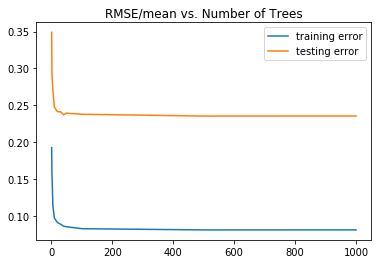

In [69]:
ises = []
mse_tr = []
mse_te = []
for i in [1, 2, 5, 10, 20, 30, 40, 50, 100, 500, 1000]:
    ises.append(i)
    results = train_and_test_forest(features, n_est = i)
    mse_tr.append(results[0])
    mse_te.append(results[1])
plt.plot(ises, mse_tr, label = 'training error')
plt.plot(ises, mse_te, label = 'testing error')
plt.title('RMSE/mean vs. Number of Trees')
plt.legend()
plt.show()

The improvement to the error shows strongly diminishing returns when using more than about 50 trees to construct the forest. the strong difference in errors could be caused by the individual trees being too complex. This should be addressed next:

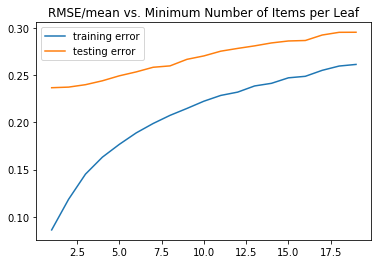

In [70]:
ises = []
mse_tr = []
mse_te = []
for i in range(1,20):
    ises.append(i)
    results = train_and_test_forest(features,n_est = 50, min_lf = i)
    mse_tr.append(results[0])
    mse_te.append(results[1])
plt.plot(ises, mse_tr, label = 'training error')
plt.plot(ises, mse_te, label = 'testing error')
plt.title('RMSE/mean vs. Minimum Number of Items per Leaf')
plt.legend()
plt.show()

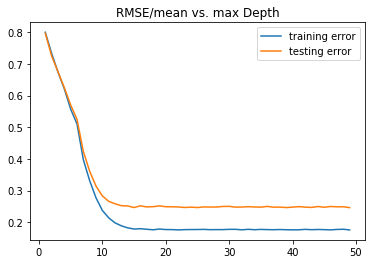

In [71]:
ises = []
mse_tr = []
mse_te = []
for i in range(1,50):
    ises.append(i)
    results = train_and_test_forest(features,n_est = 50, min_lf = 5, mx_dpth = i,nj = 4)
    mse_tr.append(results[0])
    mse_te.append(results[1])
plt.plot(ises, mse_tr, label = 'training error')
plt.plot(ises, mse_te, label = 'testing error')
plt.title('RMSE/mean vs. max Depth')
plt.legend()
plt.show()

Max depth: More than 10 leads to overfitting in individual trees

In [66]:
train_and_test_forest(features, n_est = 50, min_lf = 5, mx_dpth = 10)

(0.23736361065682451, 0.28126897084090907)

With these settings, the model performs well and the issue with overfitting is significantly reduced.

# Summary

In this project, a dataset containing information about bike rentals in Washington D.C. was used to construct different machine learning models in an attempt to predict the number of rentals on a given day. The error that was used to analyze the models was the root mean squared error divided by the mean number of rentals for the dataset being used.

The linear regression model reached an error of about 0.8 (rmse/mean). This is most likely due to the fact, that this type of model is very limited by the fact that it assumes that the features are both independent and have a linear relationship to the target value.

Next, a decision tree model was constructed, which performed much better with an error of about 0.31 on the test set. It did show signs of overfitting and in order to reduct this issue, the complexity of the tree was limited.

Finally, a random forest model was used. After optimizing the parameters of the model to again reduce the complexity of the individual trees and find the ideal number of trees, the model reached an error of 0.28.